In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import autograd as ag
import numpy as np 
import os
import copy
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import corner
import pyccl as ccl

from tqdm import tqdm, trange

from scipy.interpolate import interp1d, UnivariateSpline
from scipy.optimize import curve_fit

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.decomposition import PCA


from numpy.polynomial import Chebyshev

import src.datamaker as datamaker
import src.training as training
import src.models as models

from importlib import reload
reload(datamaker)
reload(training)
reload(models)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rcParams['figure.facecolor'] = 'white'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

In [27]:
# Load in training data
if os.path.isfile('data/Cgg_samples_120tasks_2048samples.npz'):
    with np.load('data/Cgg_samples_120tasks_2048samples.npz') as data:
        X_train = data['X_train']
        Y_train = data['Y_train']
        ell_bins = data['ell_bins']
        survey_midpoints = data['survey_midpoints']
        survey_pz = data['survey_pz']
        qrd_pz = data['qrd_pz']

print(X_train.shape)
print(Y_train.shape)

(120, 2048, 6)
(120, 2048, 30)


In [28]:
# Check if survey mid points is just tiled
tiled = True
for i in range(survey_midpoints.shape[0] - 1):
    if all(survey_midpoints[i]) != all(survey_midpoints[i+1]):
        tiled = False
        break
    
# compress the survey midpoints along the first axis
if tiled:
    survey_midpoints = survey_midpoints[0]

print(survey_midpoints.shape)

(49,)


Text(0.5, 0, '$\\ell$')

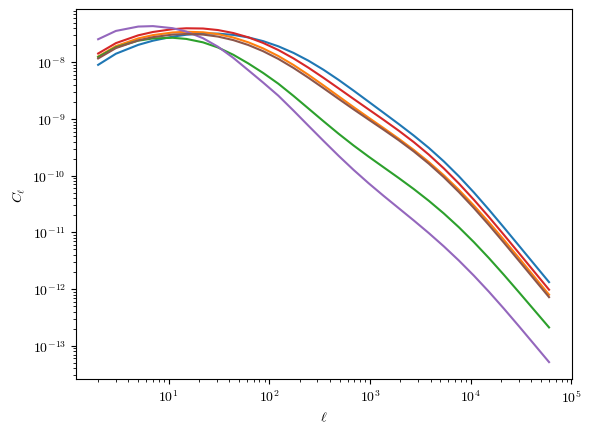

In [29]:
for i in range(2**10):
    if i % 200 == 0:
        plt.loglog(ell_bins,Y_train[19,i])
        #plt.loglog(ell_bins,np.log(Y_train[19,i]))
plt.ylabel(r'$C_{\ell}$')
plt.xlabel(r'$\ell$')

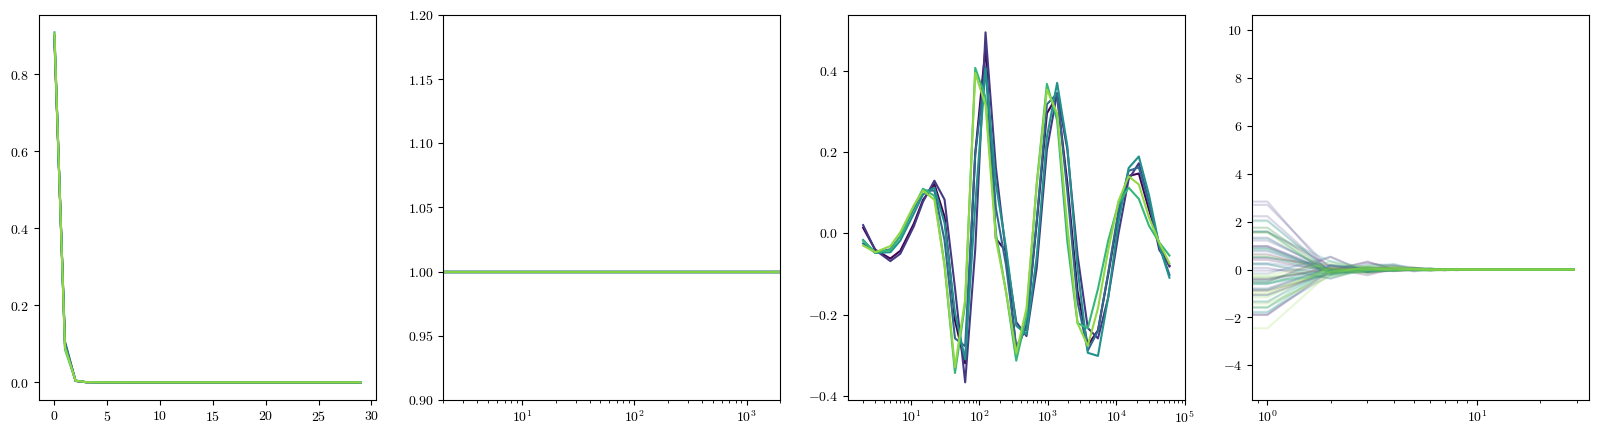

In [30]:
# Attempt to PCA the data

norm = matplotlib.colors.Normalize(vmin=0, vmax=len(Y_train))
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.viridis)

fig, ax = plt.subplots(1,4,figsize=(20,5))

# Need to run PCA individually for each survey
for i in range(Y_train.shape[0]):
    if i % 20 == 0:
        color = cmap.to_rgba(i)
        # split into training and test data
        # Need to keep test size large as model will be asked to predict far more data than it has seen
        #pca_train, pca_test = train_test_split(Y_train[i], test_size=0.8, random_state=42)

        pca = PCA(n_components=30)
        pca.fit(np.log(Y_train[i]))

        # test the PCA
        pca_test_transformed = pca.transform(np.log(Y_train[i]))

        pca_components = pca.components_
        pca_test_reconstructed = pca.inverse_transform(pca_test_transformed)

        # manually inverse transform the data
        pca_test_reconstructed = np.dot(pca_test_transformed, pca_components) + pca.mean_

        # check if the manual inverse transform is the same as the PCA inverse transform
        np.testing.assert_array_equal(pca_test_reconstructed, pca.inverse_transform(pca_test_transformed))
        
        # plot the PCA
        ax[0].plot(pca.explained_variance_ratio_, label=f'Survey {i}', c=color)
        ax[2].plot(ell_bins, pca_components[9,:], label=f'Survey {i}', c=color)
        ax[2].set_xscale('log')
        for j in range(len(Y_train[i])):
            if j % 200 == 0:
                ax[1].plot(ell_bins, np.exp(pca_test_reconstructed[j])/Y_train[i,j], c=color, alpha=0.2)
                ax[1].set_xscale('log')
                ax[1].set_xlim(2,2000)
                ax[1].set_ylim(0.9,1.2)

                ax[3].plot(pca_test_transformed[j], c=color, alpha=0.2)
                ax[3].set_xscale('log')
                #ax[3].loglog(Y_train[i,j], c=color, alpha=0.2)


- Need to train over

In [24]:
print(pca_components.shape)
print(pca_test_transformed.shape)

(30, 418)
(1024, 30)


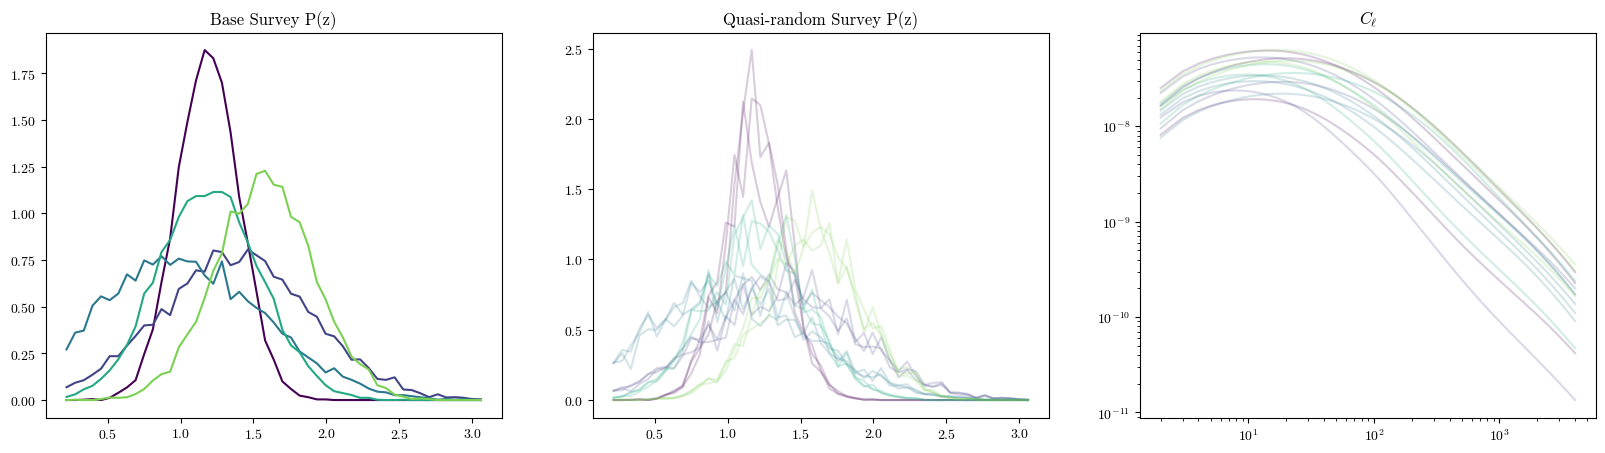

In [25]:
# Plot survey distributions and Cell to see which ones perfrom poorly

fig, ax = plt.subplots(1,3,figsize=(20,5))

for i in range(Y_train.shape[0]):
    if i % 20 == 0:
        color = cmap.to_rgba(i)
        ax[0].plot(survey_midpoints, survey_pz[i], c=color)
        ax[0].set_title('Base Survey P(z)')

        for j in range(Y_train.shape[1]):
            if j % 400 == 0:
                ax[1].plot(survey_midpoints, qrd_pz[i,j], c=color, alpha=0.2)
                ax[1].set_title('Quasi-random Survey P(z)')

                ax[2].loglog(ell_bins, Y_train[i,j,:], c=color, alpha=0.2)
                ax[2].set_title(r'$C_{\ell}$')

# Log-spectra approach

Plotting task [110]
Training samples: [ 790 1832 1878  747 1134  208  990 1104  870 1499 1863 1986 1675  151
 1877 1300 1105  593 1923 1133  311  286 1273  777 1489 1715 1929  415
 1417 1071  137 1064 1083  610 1002 1268  547  451  111  931   48 1019
  399 1930 1035 1382  240 1126 1778 1988 1751 1951  178  229 1099  130
 1287 1558 1968  718  196  123 1842 1766  192  248 1919  112  848 1736
 1096 1617  782  941 1135   24  101  468 1673 1275 1393 1124 1674  774
 1325 1881  268   20  709    9  920  783 1467 1785 1752  734 1439 1110
  433  442 1984  954  295 1354  407   51  182  526 1876  345 1406 1830
  462 1599 1272 2043  833 1884 1677  663  812  146 1115 1482 1453  194
  381   64  444  795 1324  275 1550 1523 1136  181  236  393 1506  212
  281  590  844  900 1616  388  642 1944  535   39  395   65 1397  155
 1732 1196 1144 1396 1078  307 1352  198  948  264  875 1642 1893  496
 1445 1277  445  629  615 1909 1542 1712 1204 1297   27 1898  626  459
 1721   62 1255  379  523 1226 1154  50

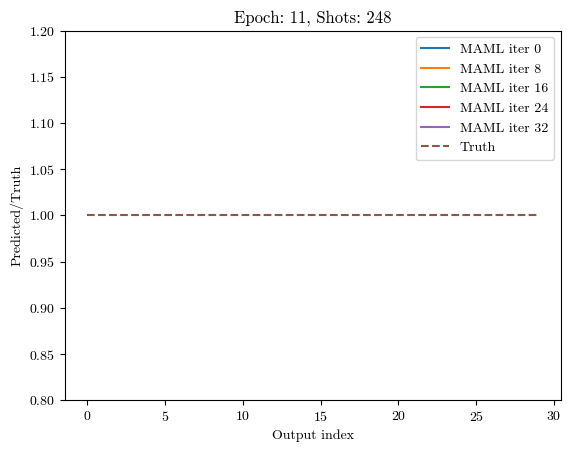

Loss: 0.2100127786397934


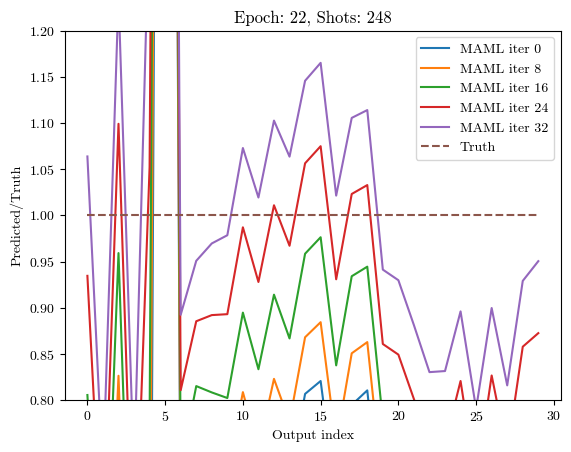

Loss: 0.003387144533917308


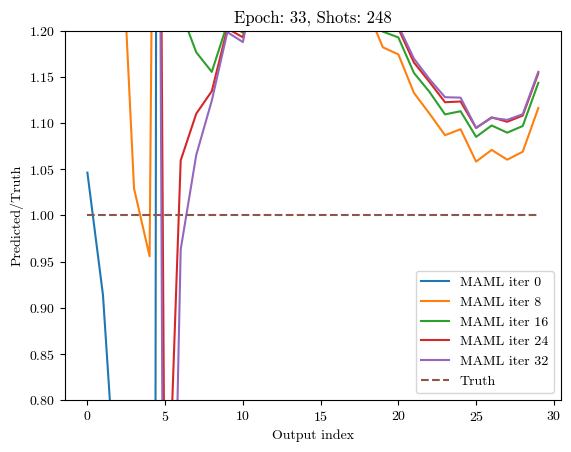

Loss: 0.012140071950852871


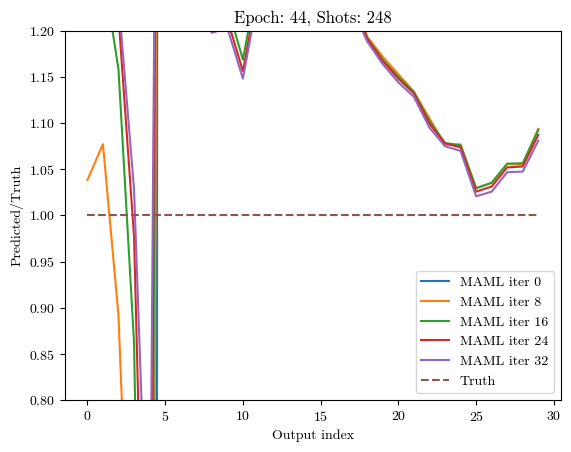

Loss: 0.006820051930844784


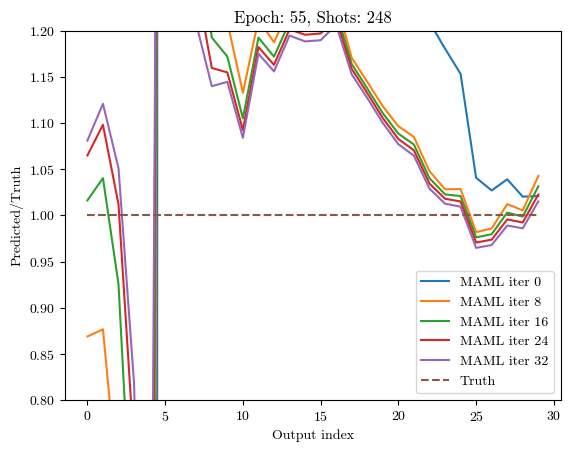

Loss: 0.003344282740727067


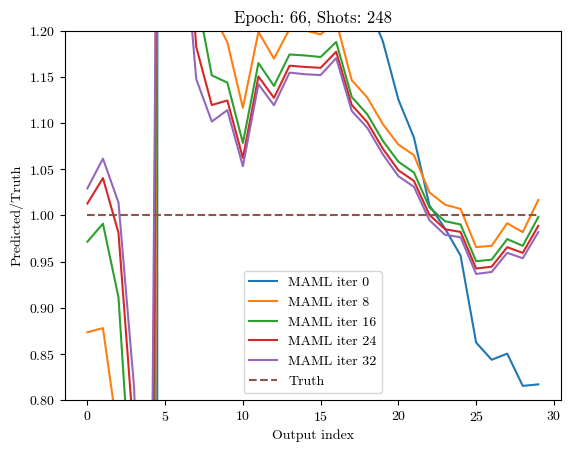

Loss: 0.002098687458783388


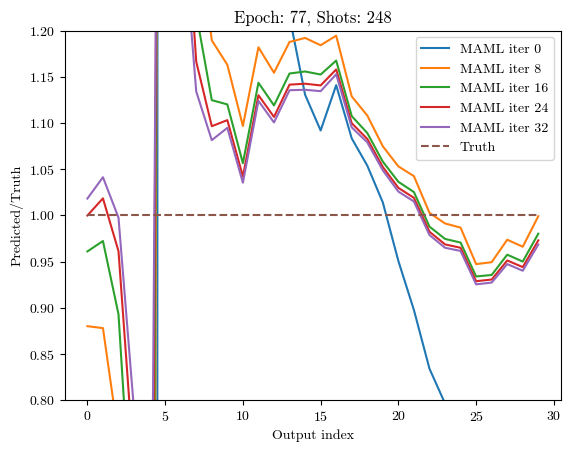

Loss: 0.0017578969709575176


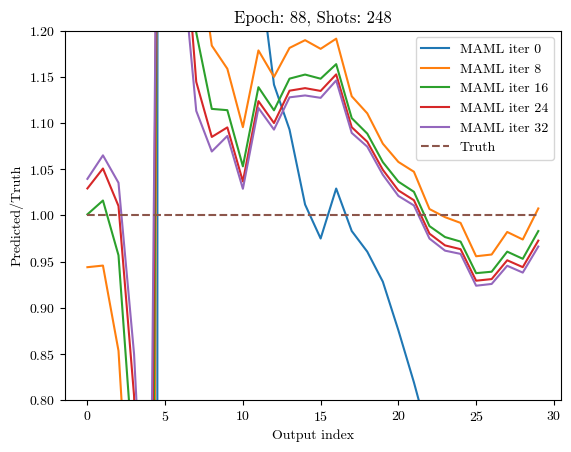

Loss: 0.0015383244026452303


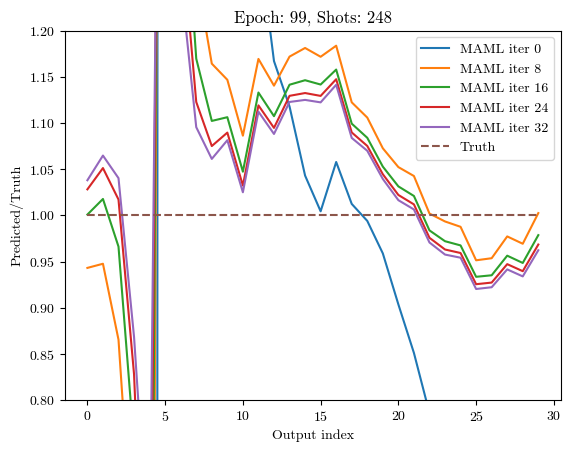

Loss: 0.0014305234653875232


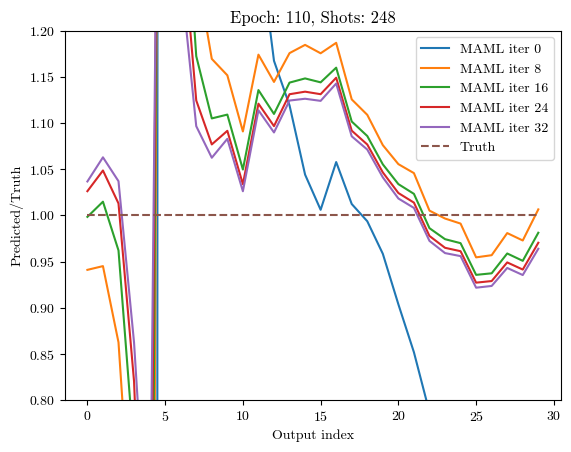

Loss: 0.0014505835715681314


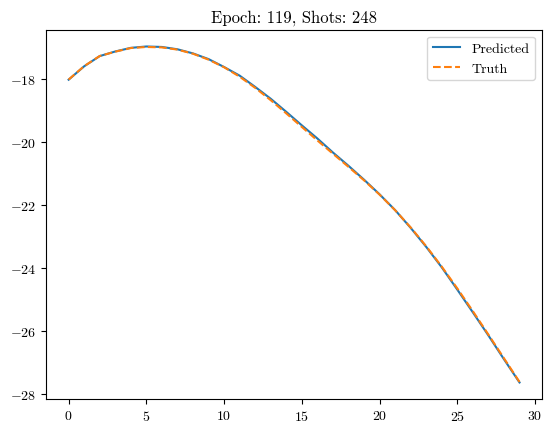

In [32]:
reload(training)

model = models.SimpleMLP(
            in_size=6,
            hidden_size=512,
            out_size=Y_train.shape[2]
        )

# Take logarithm of spectra in Y_train
Y_train_log = np.log(Y_train)

# MAML train model
CosyMAML_log = training.MAML(
            model=model,
            seed=14
        )

loss_MAML_log = CosyMAML_log.meta_train(
    x_train=X_train,
    y_train=Y_train_log,
    inner_lr=0.02,
    outer_lr=0.5,
    inner_decay=1e-3,
    outer_decay=1e-2,
    loss_fn=nn.MSELoss(),
    spt_frac=0.6,
    outer_epochs=1,
    inner_epochs=32,
    plot_prog=True,
    scale=True,
    n_shots=248
)

# PCA approach

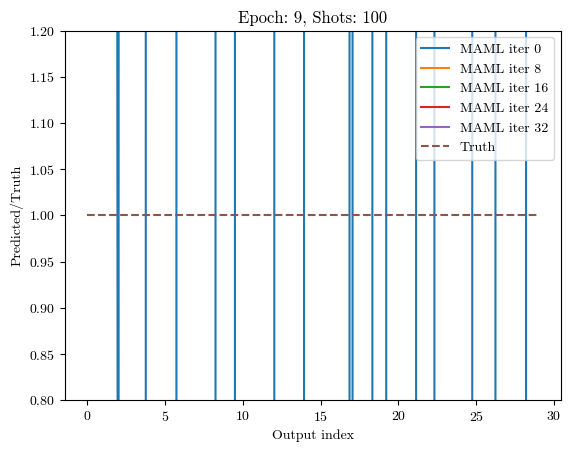

Loss: nan


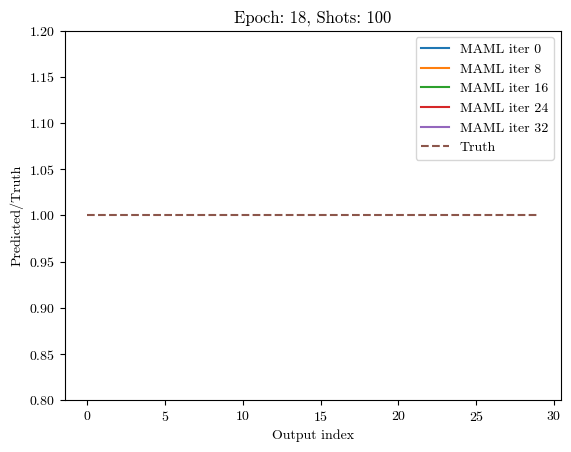

Loss: nan


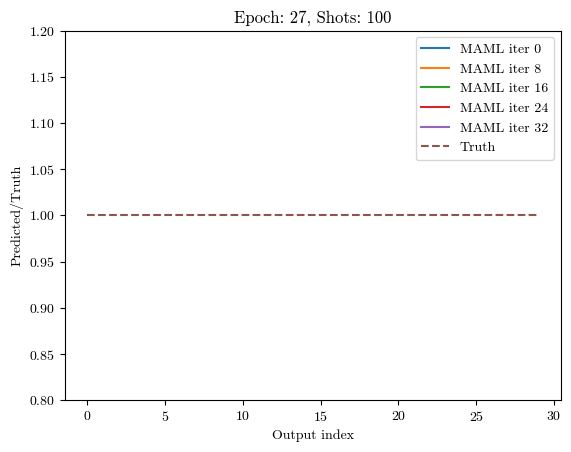

Loss: nan


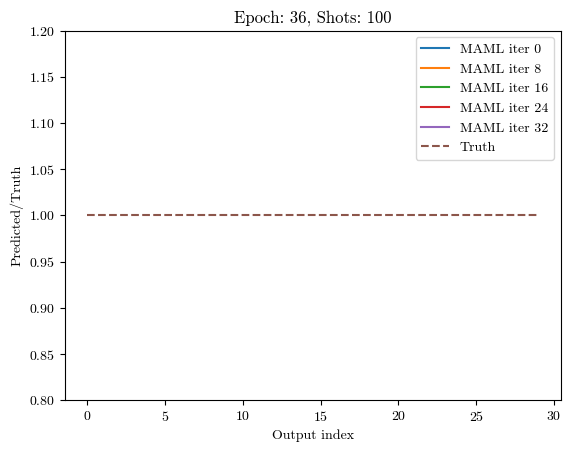

Loss: nan


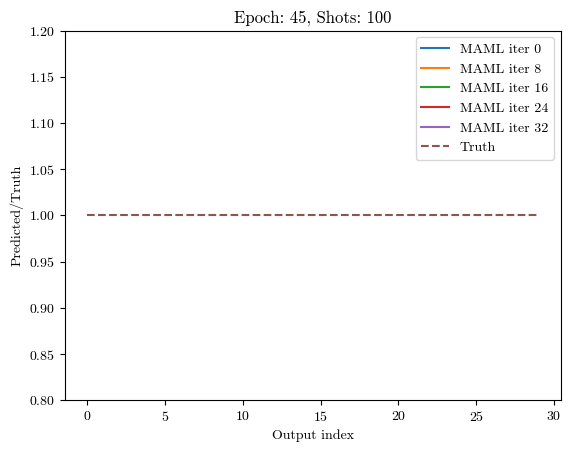

Loss: nan


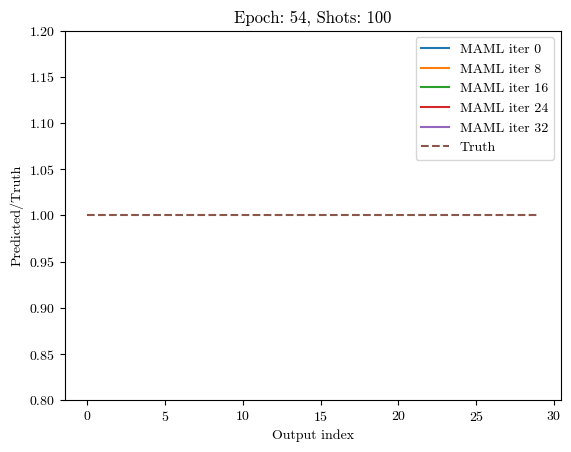

Loss: nan


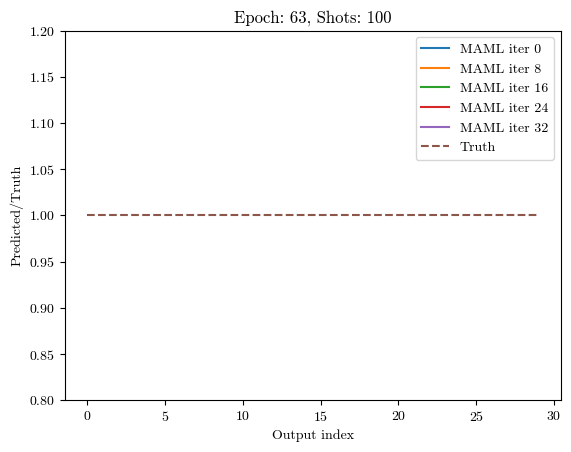

Loss: nan


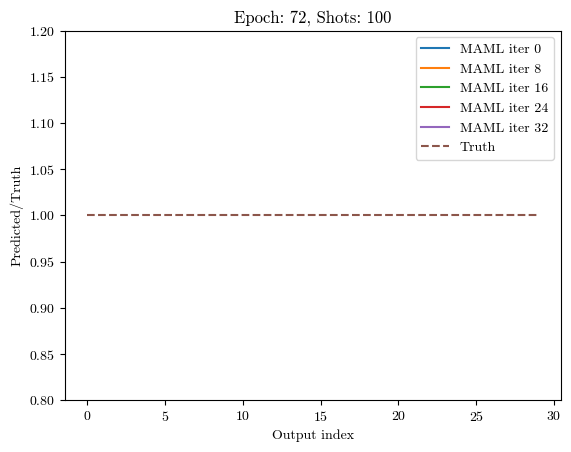

Loss: nan


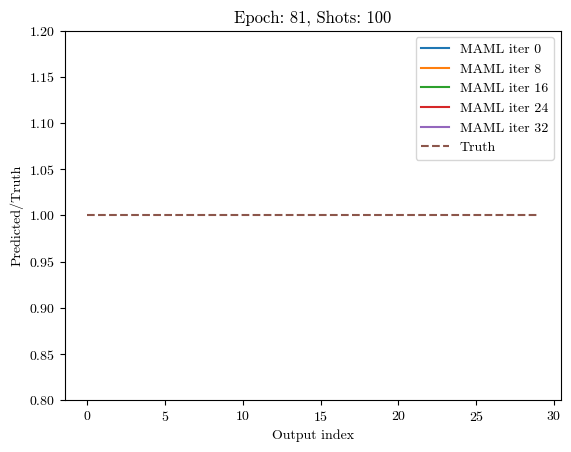

Loss: nan


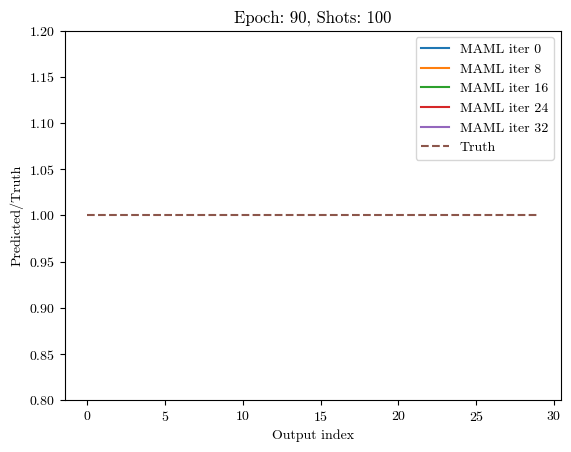

Loss: nan


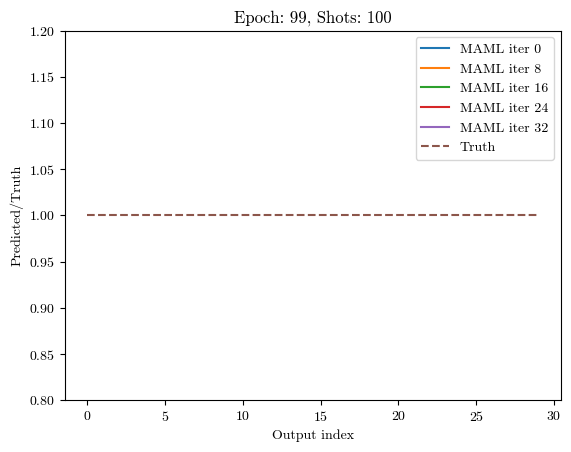

Loss: nan


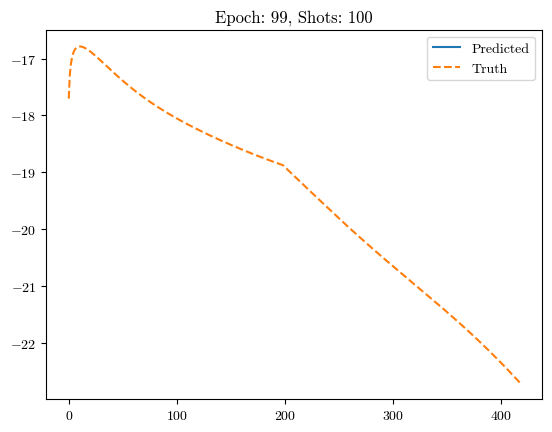

In [26]:
reload(models)
reload(training)

n_out = 30

Y_train_log = np.log(Y_train)

model = models.SimpleMLP(
            in_size=6,
            hidden_size=512,
            out_size=n_out
        )

# MAML train model
CosyMAML = training.PCA_MAML(
            model=model,
            seed=14,
            pca_components=n_out
        )

loss_MAML = CosyMAML.meta_train(
    x_train=X_train,
    y_train=Y_train_log,
    inner_lr=0.02,
    outer_lr=0.5,
    inner_decay=1e-3,
    outer_decay=1e-2,
    loss_fn=nn.MSELoss(),
    spt_frac=0.6,
    outer_epochs=1,
    inner_epochs=32,
    plot_prog=True,
    n_shots=100
)

# Adam optimiser

In [55]:
import torch
import torch.autograd as ag
import numpy as np
from sklearn.preprocessing import StandardScaler
import copy
import matplotlib.pyplot as plt

class MAML():
    '''
        Class for MAML implementation of an angular power spectrum emulator.
        Uses Adam optimizer instead of SGD.
    '''
    def __init__(self, model, seed=14,
                 ):
        self.model = model
        self.seed = seed
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.rng = np.random.RandomState(seed)
        
        # Initialize Adam optimizer parameters
        self.adam_params = {}
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.adam_params[name] = {
                    'm': torch.zeros_like(param.data).to(self.device),
                    'v': torch.zeros_like(param.data).to(self.device),
                    't': 0
                }

    # convert numpy array to torch tensor
    def to_torch(self, arr):
        return ag.Variable(torch.tensor(arr, dtype=torch.float32).to(self.device))
    
    # send individual data batch to model for training step
    def train_on_batch(self, x, y, step, loss_fn, beta1=0.9, beta2=0.999, epsilon=1e-8):
        x = self.to_torch(x)
        y = self.to_torch(y)
        self.model.zero_grad()
        y_pred = self.model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                grad = param.grad.data
                adam_state = self.adam_params[name]
                
                # Update biased first moment estimate
                adam_state['m'] = beta1 * adam_state['m'] + (1 - beta1) * grad
                # Update biased second raw moment estimate
                adam_state['v'] = beta2 * adam_state['v'] + (1 - beta2) * (grad ** 2)
                adam_state['t'] += 1

                # Compute bias-corrected first moment estimate
                m_hat = adam_state['m'] / (1 - beta1 ** adam_state['t'])
                # Compute bias-corrected second raw moment estimate
                v_hat = adam_state['v'] / (1 - beta2 ** adam_state['t'])

                # Update parameters
                param.data -= step * m_hat / (torch.sqrt(v_hat) + epsilon)

    # obtain predictions from model
    # Includes built-in scaling 
    def predict(self, x):
        x = self.to_torch(x)
        return self.model(x).detach().cpu().numpy()
    
    # meta train the model
    def meta_train(self, x_train, y_train, 
                   inner_lr, outer_lr, loss_fn, 
                   spt_frac, outer_epochs, inner_epochs,
                   inner_decay=1e-4, outer_decay=1e-3, n_shots=5,
                   rec_loss=True, plot_prog=False, scale=True):
        
        # ascertaining the number of tasks and samples
        n_tasks = y_train.shape[0]
        n_samples = y_train.shape[1]
        tasks = np.arange(n_tasks)
        tasks = self.rng.permutation(tasks) # permute the order tasks are trained

        # isolate a random task for plotting the progress of training
        if plot_prog:
            task_plot = self.rng.choice(tasks, size=1)
            print('Plotting task {}'.format(task_plot))
            tasks = np.delete(tasks, task_plot)
            n_tasks = len(tasks)
            rand_inds = self.rng.choice(n_samples, size=n_shots+1, replace=False)

            scaler_x_plot = StandardScaler()
            scaler_y_plot = StandardScaler()

            x_shot = x_train[task_plot, rand_inds[:-1]]
            y_shot = y_train[task_plot, rand_inds[:-1]]

            # Fit scaler on support data and transform both support and test data
            x_shot = scaler_x_plot.fit_transform(x_shot)
            x_test = x_train[task_plot, rand_inds[-1]]
            x_test = scaler_x_plot.transform(x_test)

            y_shot = scaler_y_plot.fit_transform(y_shot)
            y_test = y_train[task_plot, rand_inds[-1]]
            y_test = scaler_y_plot.transform(y_test)

        # repeat tasks so total meta train epochs is satisfied
        if n_tasks < (outer_epochs*n_tasks):
            tasks = np.tile(tasks, int(np.ceil(outer_epochs*n_tasks/n_tasks))) 
        
        loss_rec = []
        # Outer loop
        for i, task in enumerate(tasks):
            # Create a deepcopy of the model to reset after both inner and outer loops
            weights_before = copy.deepcopy(self.model.state_dict())

            # Shuffle indices and split into support and query sets
            spt_size = int(spt_frac * n_samples)
            permu = self.rng.permutation(n_samples)
            spt_inds = permu[:spt_size]
            qry_inds = permu[spt_size:]

            # Select support and query data, then scale appropriately
            x_spt_raw = x_train[task][spt_inds, :]
            y_spt_raw = y_train[task][spt_inds, :]
            x_qry_raw = x_train[task][qry_inds, :]
            y_qry_raw = y_train[task][qry_inds, :]

            # Scaling should be fit only on support set
            if scale:
                scaler_x = StandardScaler()
                scaler_y = StandardScaler()
                x_spt = scaler_x.fit_transform(x_spt_raw)
                y_spt = scaler_y.fit_transform(y_spt_raw)
                x_qry = scaler_x.transform(x_qry_raw)
                y_qry = scaler_y.transform(y_qry_raw)
            else:
                x_spt, y_spt = x_spt_raw, y_spt_raw
                x_qry, y_qry = x_qry_raw, y_qry_raw

            # Inner loop: Train on support data
            for j in range(inner_epochs):
                innerstep = inner_lr * (1 - j * inner_decay)
                self.train_on_batch(x_spt, y_spt, innerstep, loss_fn)

            # Outer loop: Evaluate and update using query data
            outerstep = outer_lr * (1 - i * outer_decay)
            self.model.zero_grad()
            y_pred = self.model(self.to_torch(x_qry))
            loss = loss_fn(y_pred, self.to_torch(y_qry))
            loss.backward()
            loss_rec.append(loss.item())

            # Reload pre-inner loop weights for the next task
            self.model.load_state_dict(weights_before)

            # Update weights using Adam for outer loop
            for name, param in self.model.named_parameters():
                if param.requires_grad:
                    grad = param.grad.data
                    adam_state = self.adam_params[name]
                    
                    # Update biased first moment estimate
                    adam_state['m'] = 0.9 * adam_state['m'] + 0.1 * grad
                    # Update biased second raw moment estimate
                    adam_state['v'] = 0.999 * adam_state['v'] + 0.001 * (grad ** 2)
                    adam_state['t'] += 1

                    # Compute bias-corrected first moment estimate
                    m_hat = adam_state['m'] / (1 - 0.9 ** adam_state['t'])
                    # Compute bias-corrected second raw moment estimate
                    v_hat = adam_state['v'] / (1 - 0.999 ** adam_state['t'])

                    # Update parameters
                    param.data -= outerstep * m_hat / (torch.sqrt(v_hat) + 1e-8)

            # Plot progress every n_tasks/10 outer epochs
            # Progress is measured as how quickly and accurately 
            # the model can adapt to a new task
            if plot_prog and (i+1) % int(len(tasks)/10) == 0:
                plt.cla()
                plt.title('Epoch: %d, Shots: %d' % (i+1, n_shots))
                weights_before = copy.deepcopy(self.model.state_dict())
                y_pred = self.predict(x_test)
                plt.plot(y_pred[0]/y_test[0], label='MAML iter 0', ls='-')
                for inneriter in range(32):
                    innerstep = inner_lr * (1 - inneriter * inner_decay)
                    self.train_on_batch(x_shot, y_shot, innerstep, loss_fn)
                    if (inneriter+1) % 8 == 0:
                        y_pred = self.predict(x_test)
                        plt.plot(y_pred[0]/y_test[0],
                                 label='MAML iter %d' % (inneriter+1),
                                 ls='-'
                                 )
                plt.plot(y_test[0]/y_test[0], label='Truth', ls='--')
                y_pred_final = self.predict(x_test)
                loss = loss_fn(self.to_torch(y_pred_final),
                               self.to_torch(y_test)
                               ).item()
                plt.legend()
                plt.xlabel('Output index')
                plt.ylabel('Predicted/Truth')
                plt.ylim([0.8, 1.2])
                plt.savefig('maml_ratio_final.pdf', bbox_inches='tight')
                plt.pause(0.01)
                self.model.load_state_dict(weights_before)
                print('Loss:',loss)

                y_pred_final = y_pred_final.reshape(1, -1)
                y_pred_final = scaler_y_plot.inverse_transform(y_pred_final)
                y_test = y_test.reshape(1, -1)
                y_test = scaler_y_plot.inverse_transform(y_test)

                plt.figure()
                plt.title('Epoch: %d, Shots: %d' % (i+1, n_shots))
                plt.plot(y_pred_final[0], label='Predicted')
                plt.plot(y_test[0], ls='--', label='Truth')
                plt.legend()
                plt.savefig('maml_output_final.pdf', bbox_inches='tight')

        if rec_loss:
            return loss_rec
        
    def finetune_predict(self, x_train, y_train, x_test, adapt_steps):
        weights_before = copy.deepcopy(self.model.state_dict())
        for i in range(adapt_steps):
            innerstep = self.inner_lr * (1 - i * self.inner_decay)
            self.train_on_batch(x_train, y_train, innerstep)
        y_pred = self.predict(x_test)
        self.model.load_state_dict(weights_before)
        return y_pred

Plotting task [110]


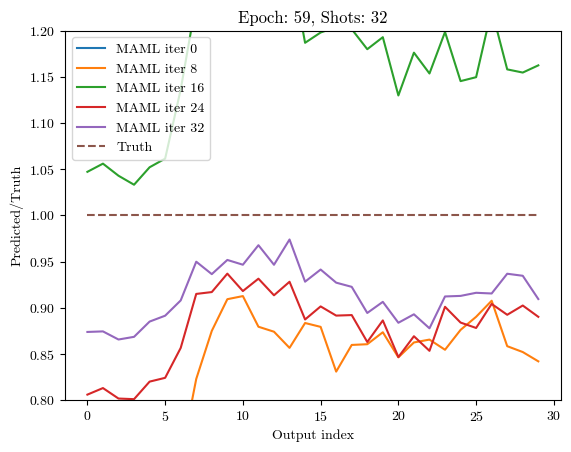

Loss: 0.0065794275142252445


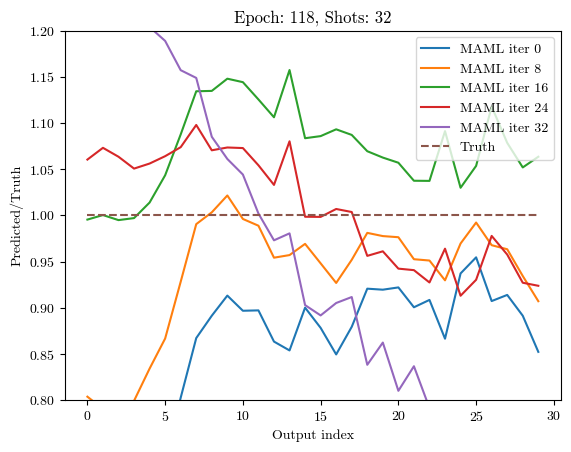

Loss: 0.024629460647702217


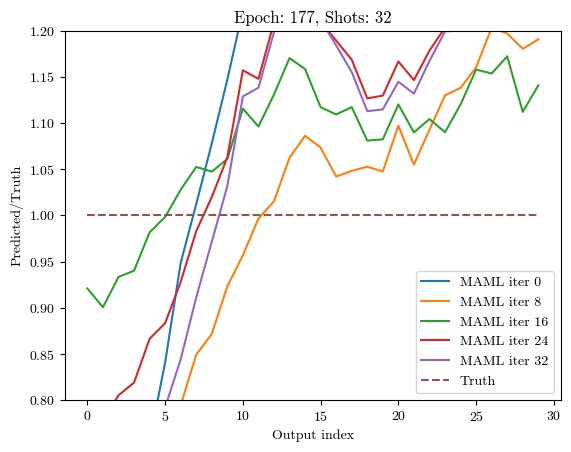

Loss: 0.03045368380844593


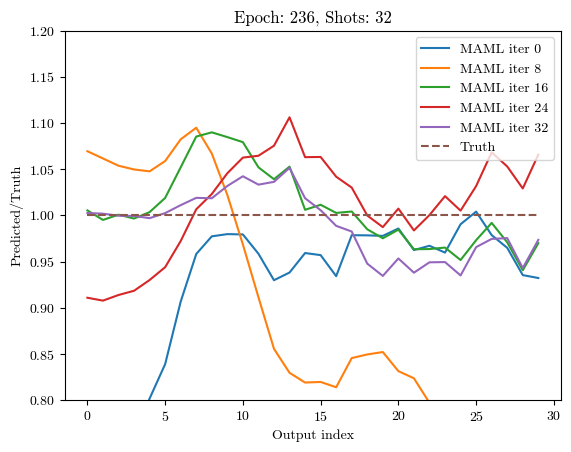

Loss: 0.0005724843358621001


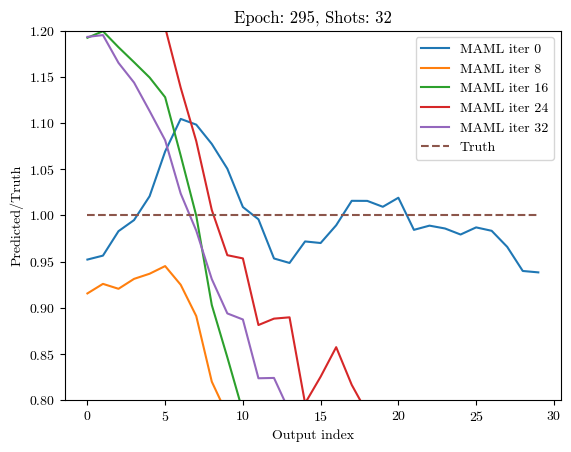

Loss: 0.028249073773622513


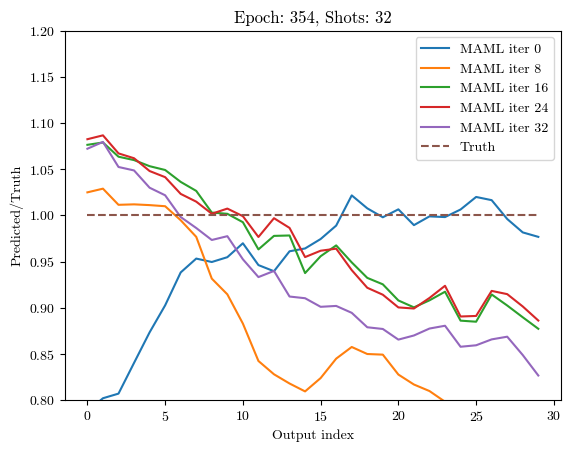

Loss: 0.004146135412156582


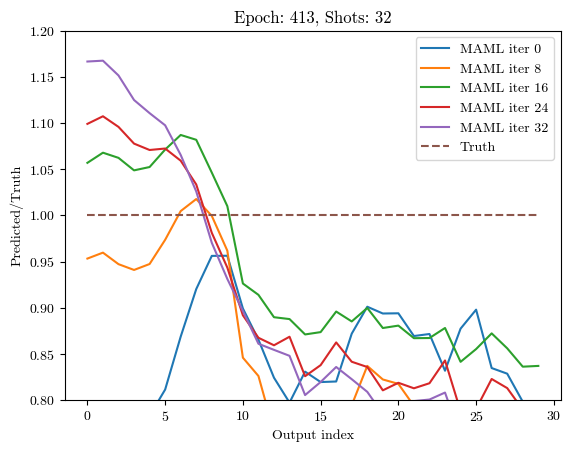

Loss: 0.015158423222601414


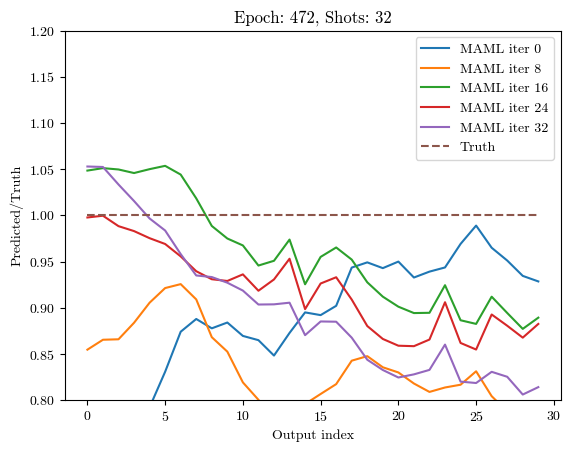

Loss: 0.006592176854610443


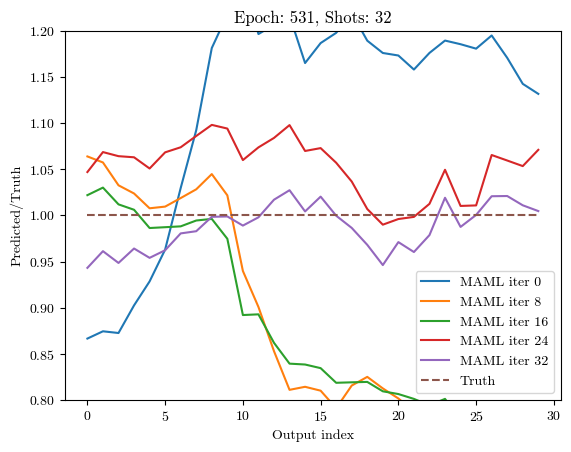

Loss: 0.0006969518144614995


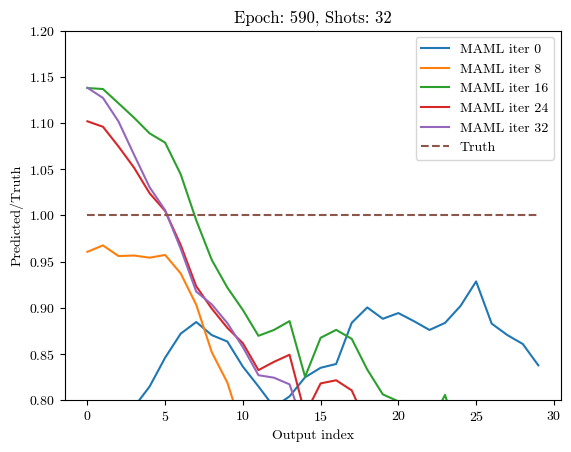

Loss: 0.02126065082848072


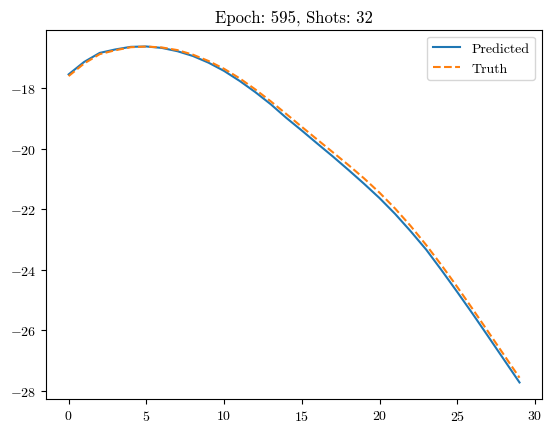

In [53]:
reload(training)

model = models.SimpleMLP(
            in_size=6,
            hidden_size=512,
            out_size=Y_train.shape[2]
        )

# Take logarithm of spectra in Y_train
Y_train_log = np.log(Y_train)

# MAML train model
CosyMAML_log = MAML(
            model=model,
            seed=14
        )

loss_MAML_log = CosyMAML_log.meta_train(
    x_train=X_train,
    y_train=Y_train_log,
    inner_lr=0.001,
    outer_lr=0.01,
    inner_decay=1e-5,
    outer_decay=1e-4,
    loss_fn=nn.MSELoss(),
    spt_frac=0.5,
    outer_epochs=5,
    inner_epochs=5,
    plot_prog=True,
    scale=True,
    n_shots=32
)

# Grid search

In [56]:
import itertools
import numpy as np

def grid_search_maml(X_train, Y_train, model_class, param_grid, seed=14):
    # Helper function to update model parameters
    def update_model_params(model_class, params):
        return model_class(**params)

    # Create all combinations of hyperparameters
    param_combinations = list(itertools.product(*param_grid.values()))
    param_names = list(param_grid.keys())
    
    best_loss = float('inf')
    best_params = None
    results = []

    for combo in tqdm(param_combinations):
        params = dict(zip(param_names, combo))
        
        # Print the current combination of hyperparameters
        #print(f"Evaluating combination: {params}")
        
        # Create and initialize the model with the given hyperparameters
        model_params = {k: v for k, v in params.items() if k in ['in_size', 'hidden_size', 'out_size']}
        model = update_model_params(model_class, model_params)
        
        # Take logarithm of spectra in Y_train
        Y_train_log = np.log(Y_train)
        
        # Create the MAML instance
        CosyMAML_log = MAML(model=model, seed=seed)
        
        # Perform meta-training
        loss_MAML_log = CosyMAML_log.meta_train(
            x_train=X_train,
            y_train=Y_train_log,
            inner_lr=params['inner_lr'],
            outer_lr=params['outer_lr'],
            inner_decay=params['inner_decay'],
            outer_decay=params['outer_decay'],
            loss_fn=params['loss_fn'],
            spt_frac=params['spt_frac'],
            outer_epochs=params['outer_epochs'],
            inner_epochs=params['inner_epochs'],
            plot_prog=False,  # Disable plotting for grid search
            scale=True,
            n_shots=params['n_shots']
        )
        
        # Compute the mean loss over the training process
        mean_loss = np.mean(loss_MAML_log)
        results.append((params, mean_loss))
        
        # Check if we have found a new best loss
        if mean_loss < best_loss:
            best_loss = mean_loss
            best_params = params
        
        #print(f"Mean loss: {mean_loss}\n")
    
    return best_params, best_loss, results

# Example usage of grid_search_maml
param_grid = {
    'in_size': [6],
    'hidden_size': [512],
    'out_size': [Y_train.shape[2]],
    'inner_lr': [0.001, 0.002],
    'outer_lr': [0.01, 0.05],
    'inner_decay': [1e-5, 1e-4],
    'outer_decay': [1e-4, 1e-3],
    'loss_fn': [nn.MSELoss()],
    'spt_frac': [0.5, 0.6],
    'outer_epochs': [1, 5],
    'inner_epochs': [5, 32],
    'n_shots': [10, 100]
}

best_params, best_loss, results = grid_search_maml(X_train, Y_train, models.SimpleMLP, param_grid)
print(f"Best parameters: {best_params}")
print(f"Best loss: {best_loss}")

Evaluating combination: {'in_size': 6, 'hidden_size': 512, 'out_size': 30, 'inner_lr': 0.001, 'outer_lr': 0.01, 'inner_decay': 1e-05, 'outer_decay': 0.0001, 'loss_fn': MSELoss(), 'spt_frac': 0.5, 'outer_epochs': 1, 'inner_epochs': 5, 'n_shots': 10}
Mean loss: 0.18251750036142766

Evaluating combination: {'in_size': 6, 'hidden_size': 512, 'out_size': 30, 'inner_lr': 0.001, 'outer_lr': 0.01, 'inner_decay': 1e-05, 'outer_decay': 0.0001, 'loss_fn': MSELoss(), 'spt_frac': 0.5, 'outer_epochs': 1, 'inner_epochs': 5, 'n_shots': 100}
Mean loss: 0.3076182559520627

Evaluating combination: {'in_size': 6, 'hidden_size': 512, 'out_size': 30, 'inner_lr': 0.001, 'outer_lr': 0.01, 'inner_decay': 1e-05, 'outer_decay': 0.0001, 'loss_fn': MSELoss(), 'spt_frac': 0.5, 'outer_epochs': 1, 'inner_epochs': 32, 'n_shots': 10}
Mean loss: 0.03992066456315418

Evaluating combination: {'in_size': 6, 'hidden_size': 512, 'out_size': 30, 'inner_lr': 0.001, 'outer_lr': 0.01, 'inner_decay': 1e-05, 'outer_decay': 0.0001,